In [ ]:
# =========================
# 에어비앤비 커뮤니티 글 토픽 모델링
# =========================

import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# -------------------------
# 1. 데이터 로드
# -------------------------
df = pd.read_csv("airbnb_community_cleaning.csv")

# 중복값 및 결측치 제거
df = df.drop_duplicates(subset=["text"])
df = df.dropna(subset=["text"])

texts = df["text"].tolist()

In [ ]:
# -------------------------
# 2. 텍스트 전처리
# -------------------------
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and token.text not in STOP_WORDS
    ]
    return " ".join(tokens)

clean_texts = [preprocess(t) for t in texts]

In [ ]:
# -------------------------
# 3. 벡터화
# -------------------------
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
X = vectorizer.fit_transform(clean_texts)

In [ ]:
# -------------------------
# 4. 모델 트레이닝
# -------------------------
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
# -------------------------
# 5. 토픽 확인
# -------------------------
def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}: ",
              [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out())

Topic 0:  ['guest', 'airbnb', 'protocol', 'long', 'cleaning', 'host', 'clean', 'house', 'check', 'take']
Topic 1:  ['cleaning', 'clean', 'service', 'thank', 'look', 'host', 'company', 'airbnb', 'guest', 'hello']
Topic 2:  ['clean', 'guest', 'cleaning', 'service', 'airbnb', 'find', 'host', 'look', 'home', 'place']
Topic 3:  ['cleaning', 'fee', 'guest', 'clean', 'charge', 'host', 'stay', 'airbnb', 'pay', 'day']
Topic 4:  ['clean', 'leave', 'host', 'cleaning', 'use', 'guest', 'house', 'towel', 'want', 'linen']


In [ ]:
# -------------------------
# 6. 포스트 별 토픽 할당
# -------------------------
topic_values = lda.transform(X)
df["topic"] = topic_values.argmax(axis=1)

In [ ]:
# =========================
# 7. 시각화
# =========================
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE

feature_names = vectorizer.get_feature_names_out()

In [ ]:
stopwords = set(STOP_WORDS)
stopwords.update(['thank', 'clean', 'airbnb', 'guest', 'host', 'hello', 'hi',
                  'place', 'home', 'house', 'stay', 'room', 'day'])

topic_labels = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E"}

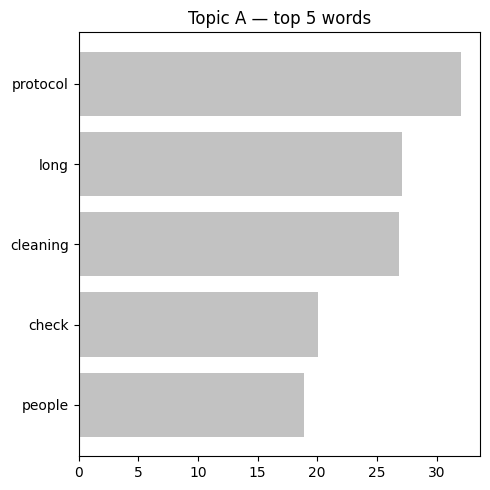

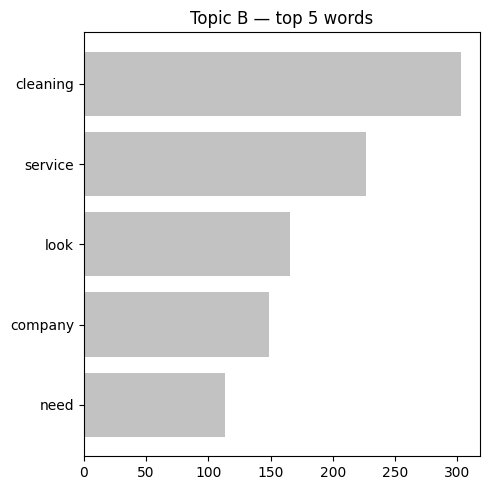

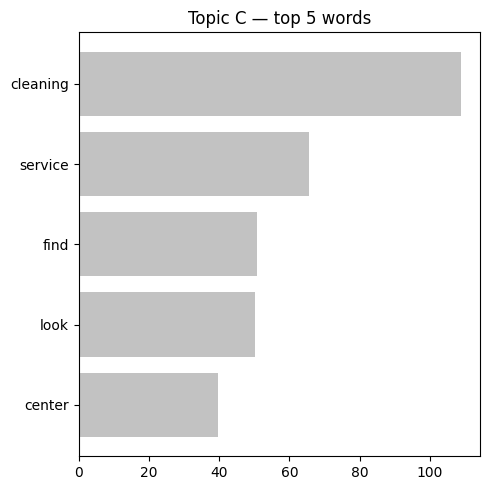

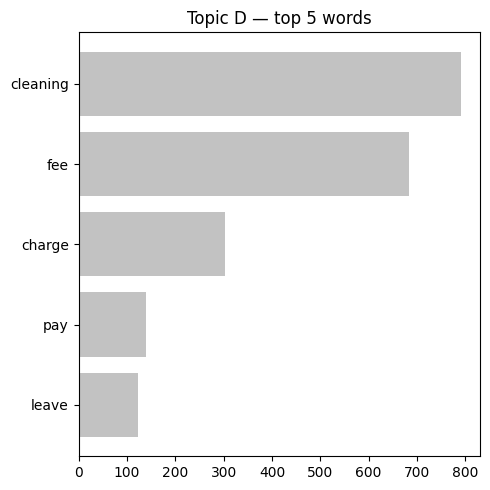

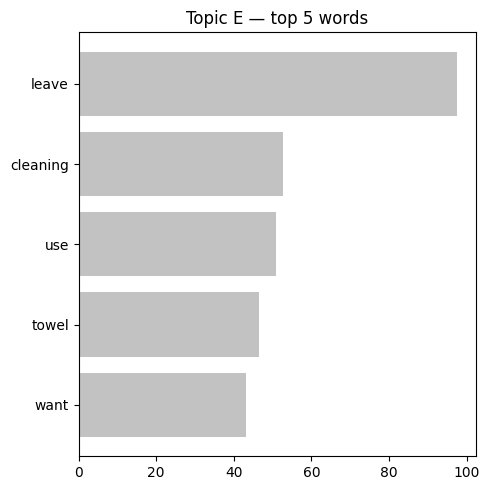

In [ ]:
def plot_top_words_inline(model, feature_names, n_top_words=12, stopwords=None, topic_labels=None):
    for topic_idx, topic in enumerate(model.components_):

        sorted_idx = topic.argsort()[::-1]

        words = []
        weights = []
        for i in sorted_idx:
            word = feature_names[i]
            if stopwords and word in stopwords:
                continue
            words.append(word)
            weights.append(topic[i])
            if len(words) == n_top_words:
                break

        label = topic_labels.get(topic_idx, topic_idx) if topic_labels else topic_idx

        plt.figure(figsize=(5, 5))
        plt.barh(range(len(words)), weights, color='#c2c2c2')
        plt.gca().invert_yaxis()
        plt.yticks(range(len(words)), words)
        plt.title(f"Topic {label} — top {n_top_words} words")
        plt.tight_layout()
        plt.show()

# 토픽 별 상위 5개 단어 출력
plot_top_words_inline(lda, feature_names, n_top_words=5, stopwords=stopwords, topic_labels=topic_labels)

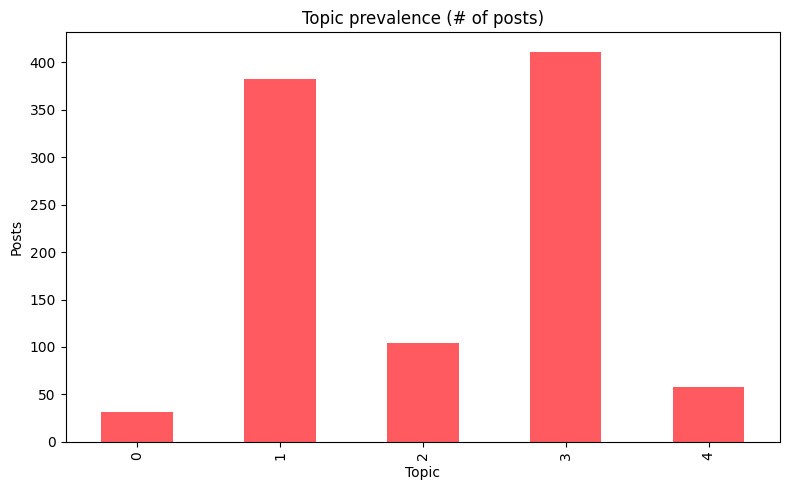

In [ ]:
# 토픽 클러스터 별 포스트 수
topic_counts = df["topic"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
topic_counts.plot(kind="bar", color="#ff5a5f")
plt.title("Topic prevalence (# of posts)")
plt.xlabel("Topic")
plt.ylabel("Posts")
plt.tight_layout()
plt.show()

In [ ]:
stopwords = set(STOP_WORDS)
stopwords.update(['thank', 'clean', 'airbnb', 'guest', 'host', 'hello', 'hi',
                  'place', 'home', 'house', 'stay', 'room'])


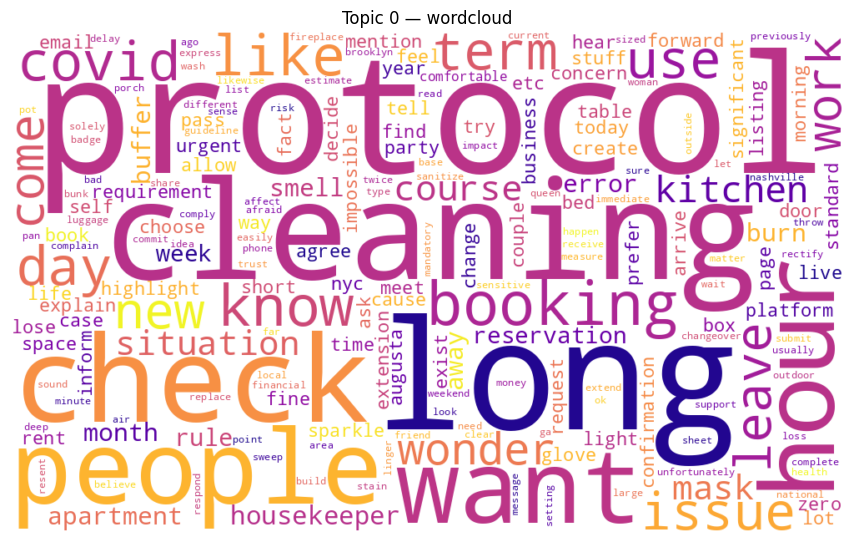

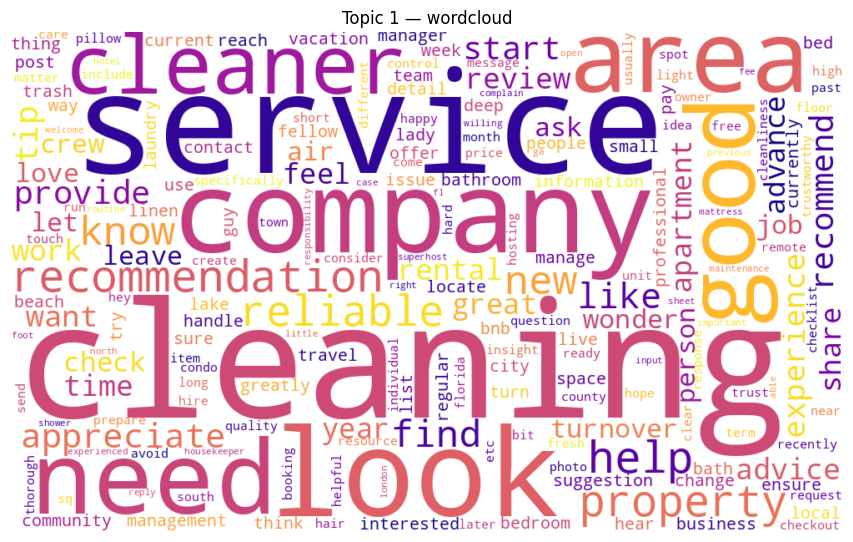

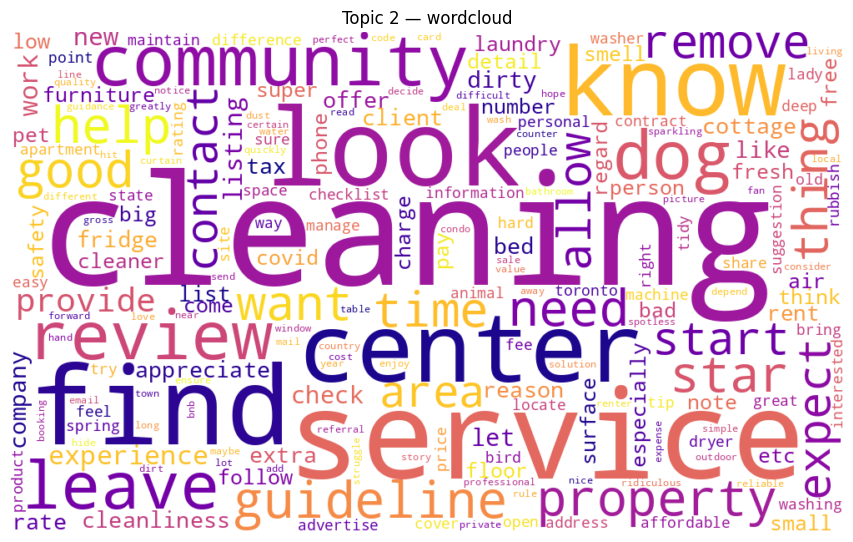

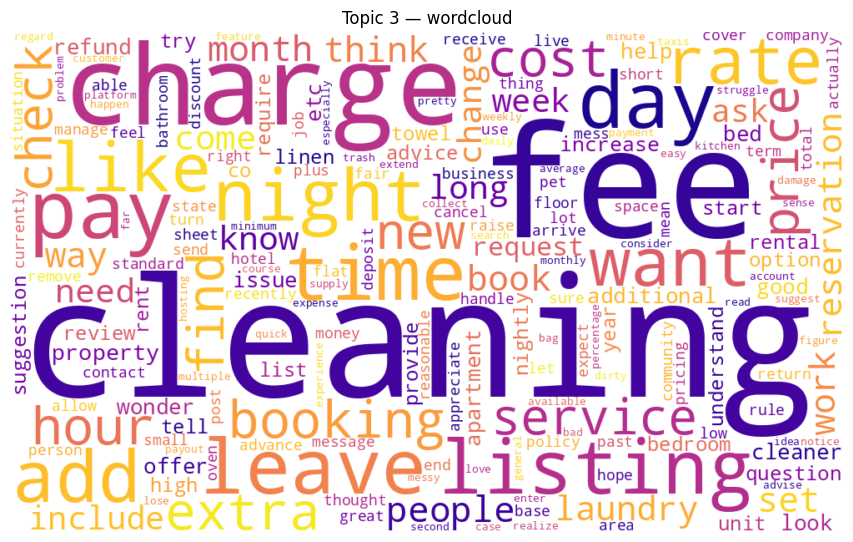

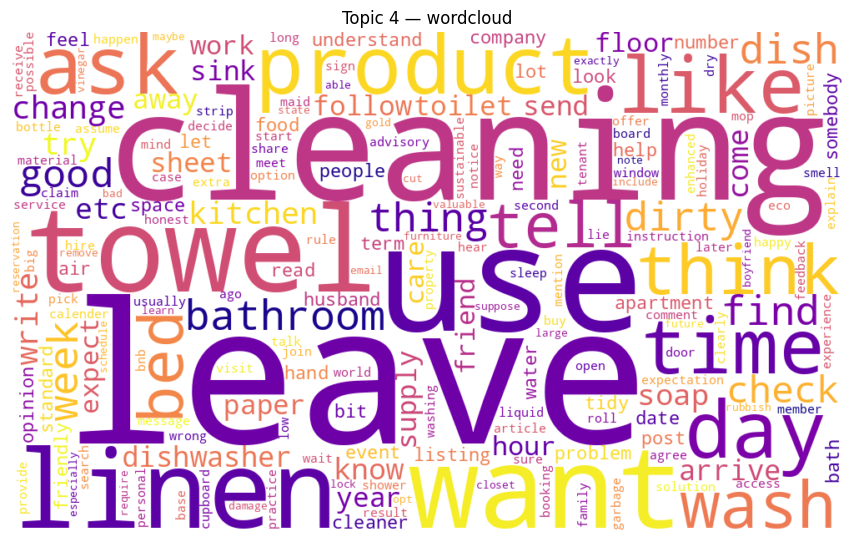

In [ ]:
# 토픽별 워드클라우드 출력
for k in range(lda.n_components):
    freqs = {feature_names[i]: float(lda.components_[k, i])
             for i in range(len(feature_names))}
    filtered_freqs = {word: freq for word, freq in freqs.items() if word not in stopwords}

    wc = WordCloud(width=1000, height=600, background_color="white",
                   colormap="plasma", stopwords=stopwords).generate_from_frequencies(filtered_freqs)

    plt.figure(figsize=(9, 5.5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {k} — wordcloud")
    plt.tight_layout()
    plt.show()